In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from numpy import datetime64
from ipywidgets import interact 
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.simplefilter('ignore')
from dask.diagnostics import ProgressBar
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from numpy.fft import *

In [2]:
from esdl.cube_store import CubesStore
cs = CubesStore()
cs

CUBE_V2.0.0_global_spatially_optimized_0.25deg,Global data cube at a spatial resolution of 0.25 degrees and a temporal resolution of 8 days with a 1x720x1440 (time x lat x lon) chunking
CUBE_V2.0.0_global_time_optimized_0.25deg,Global data cube at a spatial resolution of 0.25 degrees and a temporal resolution of 8 days with a 184x90x90 (time x lat x lon) chunking
CUBE_V2.0.0_colombia_spatially_optimized_0.083deg,Colombian data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x336x276 (time x lat x lon) chunking
CUBE_V2.0.0_global_spatially_optimized_0.083deg,Global data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x2160x4320 (time x lat x lon) chunking
CUBE_V2.0.0_global_time_optimized_0.083deg,Global data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 184x270x270 (time x lat x lon) chunking
CUBE_V2.0.0_colombia_spatially_optimized_0.0083deg,Colombian data cube at a spatial resolution of 0.0083 degrees and a temporal resolution of 8 days with a 1x3360x2760 (time x lat x lon) chunking
CUBE_V2.0.0_colombia_time_optimized_0.0083deg,Colombian data cube at a spatial resolution of 0.0083 degrees and a temporal resolution of 8 days with a 184x60x60 (time x lat x lon) chunking
CUBE_V2.0.1_colombia_spatially_optimized_0.083deg,Colombian data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x336x276 (time x lat x lon) chunking
CUBE_V2.0.1_colombia_time_optimized_0.083deg,Colombian data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x336x276 (time x lat x lon) chunking
CUBE_V2.0.1_colombia_spatially_optimized_0.0083deg,Colombian data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x336x276 (time x lat x lon) chunking
CUBE_V2.0.1_colombia_time_optimized_0.0083deg,Colombian data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x336x276 (time x lat x lon) chunking


In [44]:
data

<xarray.Dataset>
Dimensions:                                                              (bnds: 2, lat: 336, lon: 276, time: 782)
Coordinates:
  * bnds                                                                 (bnds) int64 0 1
  * lat                                                                  (lat) float64 13.96 ... -13.96
  * lon                                                                  (lon) float64 -82.96 ... -60.04
  * time                                                                 (time) datetime64[ns] 2001-01-05 ... 2017-12-31
Data variables:
    AWC                                                                  (time, lat, lon) float32 dask.array<shape=(782, 336, 276), chunksize=(184, 60, 60)>
    Absolute_depth_to_bedrock                                            (time, lat, lon) float32 dask.array<shape=(782, 336, 276), chunksize=(184, 60, 60)>
    AnnualMeanTemperature                                                (time, lat, lon) float32 dask.arr

In [3]:
data=cs['CUBE_V2.0.1_colombia_time_optimized_0.083deg']

In [4]:
from numpy.fft import fft, ifft, fftfreq, rfftfreq, rfft, irfft

#Returns the area to explore, along with feature names of the features with less than threshold percentage of nans.
def explore_nulls(cube,lat = -4.21, lon = -69.94, threshold = 25,spacing = 5):
    area_to_explore = cube.sel(lat = slice(lat+spacing,lat-spacing), lon = slice(lon-spacing,lon+spacing))
    #random date to get the mask map
    #date='2000-11-28'
    #leave only land==2
    #area_to_explore=area_to_explore.where(area_to_explore.mask.sel(time=date)==2)
    #mask=cube.mask.sel(lat = slice(lat+spacing,lat-spacing), lon = slice(lon-spacing,lon+spacing))
    snull = area_to_explore.isnull()
    nnull = area_to_explore.notnull()
    viable_features=[]
    for i in area_to_explore.keys():
        count_null = snull[i].values.sum()
        count_nnull = nnull[i].values.sum()
        null_percentage = count_null/(count_null+count_nnull)*100
        if(null_percentage < threshold):
            print(i, "null_percentage = {:.2f}".format(null_percentage))
            viable_features.append(i)
    return area_to_explore, viable_features

#Authored by SaumyaBansal, lists the N highest values of a list
def Nmax(list1, N = 5): 
    final_list = [] 
    
    for i in range(0, N):  
        max1 = 0
        for j in range(len(list1)):      
            if list1[j] > max1: 
                max1 = list1[j];
        list1.remove(max1); 
        final_list.append(max1) 
    return final_list
    
#Find the indexes corresponding to the position of the values of list_of_max in array.
def find_Index(array,list_of_max):
    indexes = []
    for i in range(len(list_of_max)):
            indexes.append(np.argwhere(array == list_of_max[i])[0][0])
    return indexes    


#Makes zero the Fourier coefficients of farray bigger than  thethreshold.
def clean_periodicity(farray, list_of_maxes, list_of_indexes, threshold = 5):
    for i in range(len(list_of_maxes)):
        if(list_of_maxes[i]> threshold):
            farray[list_of_indexes[i]] = 0
            
            
#Returns a pandas DataFrame with the seasonality-corrected viable features.
def clean_cube(cube, central_lat, central_lon, spacing, threshold = 25):
    cube_section, features = explore_nulls(cube,lat = central_lat, lon = central_lon,threshold = threshold,spacing = spacing)
    series = []
    cube_section.load() #RAM expensive, avoid large spacing values.
    for feature in features:
        series.append(clean_feature(cube_section, feature))
    
    #return pd.concat(series, axis=1)
    return series

# panda Series with the spatial median of the corrected feature.
def clean_feature(cube_section, feature_name, fourier_threshold = 8):
    time_Series = cube_section[feature_name].dropna(dim='time').median(dim=['lat','lon'],skipna=True)
    freq = rfftfreq(len(time_Series.values), d=1/8.0) #Frequencies to use. Cycles/days, sample rate is 1/8 days 
    f_time_Series = rfft(time_Series)
    
    real_maxes = Nmax(np.abs(f_time_Series.real).tolist())
    imag_maxes= Nmax(np.abs(f_time_Series.imag).tolist())
    real_ii = find_Index(np.abs(f_time_Series.real), real_maxes)
    imag_ii = find_Index(np.abs(f_time_Series.imag), imag_maxes)
    
    clean_periodicity(f_time_Series.real,real_maxes,real_ii)
    clean_periodicity(f_time_Series.imag,imag_maxes,imag_ii)
    
    corrected_time_Series = irfft(f_time_Series, n = len(time_Series))

    #Creates a new series 
    final_Series = pd.Series(corrected_time_Series)
    dates = np.datetime_as_string(cube_section[feature_name].dropna(dim='time').coords['time'].values,unit = 'Y')
    final_Series.index = dates
    
    return final_Series

In [5]:
test=data.copy()
test.evapotranspiration
ET=test.evapotranspiration
#ET.sel(lat=0).plot()

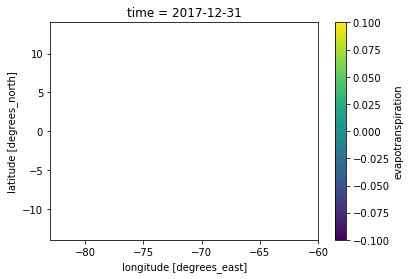

In [6]:
ET.sel(time='2017-12-31').plot()

In [7]:
ET['time']

<xarray.DataArray 'time' (time: 782)>
array(['2001-01-05T00:00:00.000000000', '2001-01-13T00:00:00.000000000',
       '2001-01-21T00:00:00.000000000', ..., '2017-12-15T00:00:00.000000000',
       '2017-12-23T00:00:00.000000000', '2017-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-01-05 2001-01-13 ... 2017-12-31
Attributes:
    bounds:         time_bnds
    long_name:      time
    standard_name:  time

In [8]:
nanmeanlat=ET.reduce(np.nanmean,dim='lat')
nanmeanlon=nanmeanlat.reduce(np.nanmean,dim='lon')
print(nanmeanlon)
nonnantime=nanmeanlon.dropna(dim='time')
nonnantimemean=nonnantime.reduce(np.mean,dim='time')
print(nonnantimemean)
fullmeanshort=nanmeanlon.sel(time=slice('2001-01-05','2015-12-31')).reduce(np.mean,dim='time')
print(fullmeanshort)

<xarray.DataArray 'evapotranspiration' (time: 782)>
array([2.740693, 2.609186, 2.477775, ...,      nan,      nan,      nan],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-05 2001-01-13 ... 2017-12-31
<xarray.DataArray 'evapotranspiration' ()>
array(2.786007, dtype=float32)
<xarray.DataArray 'evapotranspiration' ()>
array(2.786007, dtype=float32)


In [ ]:
nantime=ET.reduce(np.nanmedian,dim='lat')
nantime.reduce(fft,dim='lon')
nantime.plot()

In [10]:
with ProgressBar():
    fourier=ET.sel(time=slice('2001-01-05','2015-12-31')).reduce(np.mean,dim='time')


[########################################] | 100% Completed |  0.3s


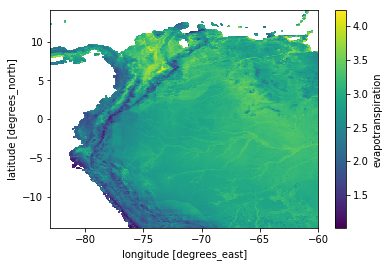

In [11]:
fourier.reduce(np.real).plot()

In [39]:
fourier=ET.sel(time=slice('2001-01-05','2015-12-31'))
stacked = fourier.stack(gridcell=['lat','lon'])
with ProgressBar():
    stacked.groupby('gridcell')
#    stacked.unstack('gridcell')
stacked

<xarray.DataArray 'evapotranspiration' (time: 690, gridcell: 92736)>
dask.array<shape=(690, 92736), dtype=float32, chunksize=(184, 3312)>
Coordinates:
  * time      (time) datetime64[ns] 2001-01-05 2001-01-13 ... 2015-12-31
  * gridcell  (gridcell) MultiIndex
  - lat       (gridcell) float64 13.96 13.96 13.96 13.96 ... 13.96 13.96 13.96
  - lon       (gridcell) float64 -82.96 -82.88 -82.79 ... -80.71 -80.63 -80.54
Attributes:
    Conventions:        CF-1.6
    easting:            -83.000388 degrees
    history:            Mon May 20 08:53:53 2019 - ESDL data cube generation
    institution:        Brockmann Consult GmbH, Germany
    northing:           14.000304 degrees
    source:             ESDL data cube generation, version 0.3.0.dev1
    source_attributes:  {'long_name': 'evapotranspiration', 'project_name': '...
    spatial_res:        0.083333 degrees

In [37]:
def standardize(x):
    return (x - x.mean()) / x.std()

In [43]:
stacked.groupby('gridcell').apply(standardize)

<xarray.DataArray 'evapotranspiration' (time: 690, gridcell: 92736)>
dask.array<shape=(690, 92736), dtype=float32, chunksize=(184, 1)>
Coordinates:
  * time      (time) datetime64[ns] 2001-01-05 2001-01-13 ... 2015-12-31
  * gridcell  (gridcell) MultiIndex
  - lat       (gridcell) float64 13.96 13.96 13.96 13.96 ... 13.96 13.96 13.96
  - lon       (gridcell) float64 -82.96 -82.88 -82.79 ... -80.71 -80.63 -80.54

In [47]:
trying=_43
a=trying.unstack().sel(time='2001-01-05')

In [50]:
a

<xarray.DataArray 'evapotranspiration' (lat: 336, lon: 276)>
dask.array<shape=(336, 276), dtype=float32, chunksize=(1, 276)>
Coordinates:
    time     datetime64[ns] 2001-01-05
  * lat      (lat) float64 13.96 13.88 13.79 13.71 ... -13.79 -13.87 -13.96
  * lon      (lon) float64 -82.96 -82.88 -82.79 -82.71 ... -60.21 -60.13 -60.04

In [ ]:
a.plot()